# Quant Research Project

This jupyter notebook contains the following parts:
1. Exploratory Data Analysis
2. Z - Score Model
3. IV Ranking Model - A percentile method to select when to trade
4. GARCH Model - Generalized Auto Regressive Conditional Heteroskedasticity Model to predict volatility spread 

# Exploratory Data Analysis

Given data has a few missing points. It also has IV values for non-market hours and holidays. I have cleaned the data and added approximate values for missing points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_parquet('data.parquet')

In [2]:
df.index = pd.to_datetime(df.index)
# Removing Weekends and Non-Market Hours
filtered_df = df[
    (df.index.dayofweek < 5) &  
    (df.index.time >= pd.to_datetime("09:15").time()) &  
    (df.index.time <= pd.to_datetime("15:30").time())
]

In [3]:
# Checking for missing data
if filtered_df.isnull().any().any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

# Calculating number of missing values for all columns
missing_data = filtered_df.isnull().sum()

# Printing number of missing values for all columns
print(missing_data)

There are missing values in the DataFrame.
banknifty    267
nifty        350
tte            0
dtype: int64


In [4]:
# Created a function which would fill empty cells with the average value of IV before and after the cell
# This assumption came from an observation of the dataset
def fill_missing_with_avg(df):
    for column in df.columns:
        for i, index_value in enumerate(df.index):
            if pd.isna(df.loc[index_value, column]):
                above = df.loc[df.index[i - 1], column] if i > 0 else None
                below = df.loc[df.index[i + 1], column] if i < len(df) - 1 else None
                if pd.notna(above) and pd.notna(below):
                    df.loc[index_value, column] = (above + below) / 2
                elif pd.notna(above):
                    df.loc[index_value, column] = above
                elif pd.notna(below):
                    df.loc[index_value, column] = below
                # If both above and below are NaN, the missing value remains NaN
    return df

filled_df = fill_missing_with_avg(filtered_df)

In [5]:
# Checking if there is missing data now, since there was a case where both values above and below would be NaN, would leave NaN
if filled_df.isnull().any().any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

missing_data = filled_df.isnull().sum()

print(missing_data)

No missing values found in the DataFrame.
banknifty    0
nifty        0
tte          0
dtype: int64


In [6]:
df = filled_df.copy(deep=True)
df['Spread'] = df['banknifty'] - df['nifty']

Text(0.5, 1.0, 'Spread Vs Time')

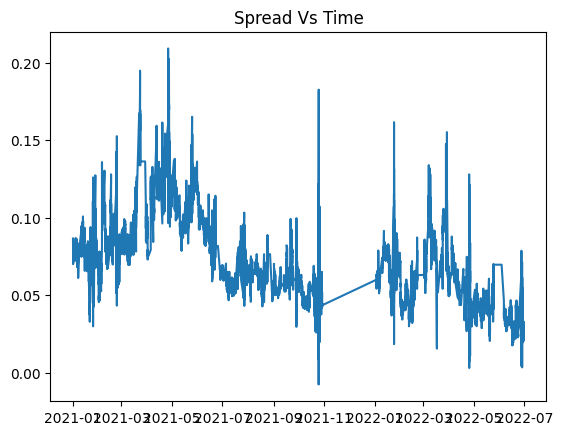

In [7]:
plt.plot(df['Spread'])
plt.title("Spread Vs Time")

The spreads do not have stationarity. We can see it has changing variance at different time periods - **Heteroskedasiticity**. We will induce stationarity while trying to apply the __GARCH__ model.

# Z - Score Strategy

The P/L formula we were given in assignment was
P/L = (Bank Nifty IV - Nifty IV)* (Time to Expiry) ** 0.7
However, at most (>99.9%) times in the dataframe, Bank Nifty IV is greater than Nifty IV. P/L was always positive.
In such a case, there is no scope for a strategy. I have applied certain assumptions to make this a bit fair trading strategy.

We are calculating the z-score of spread and applying mean reversion strategy to the spread.
We short the spread when it exceeds the z-score threshold and long it when it is less than negative z-score threshold

The PnL Formula I have used it :
    P/L = (Difference in Spread) * (Time to Expiry) ** 0.7

In [8]:
def z_score(data, period=1125):
  rol_mean = data.rolling(period).mean()
  rol_std = data.rolling(period).std()
  z = (data-rol_mean)/rol_std
  return z

df['z-score'] = z_score(df['Spread']) # calculating z-score using a rolling window of 1 day

In [9]:
df

,banknifty,nifty,tte,Spread,z-score
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,NaN
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,NaN
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,NaN
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,NaN
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,NaN
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,-0.242929
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.413196
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,-0.307298


In [10]:
z_scores = df['z-score']
spreads = df['Spread']
ttes = df['tte']
times = df.index.values
signal_type = []
entry_time_new = []
exit_time_new = []
spread_for_entry_new = []
spread_for_exit_new = []
pnl_new = []

number_of_long_trades = 0
number_of_short_trades = 0

long = False
short = False
z_threshold = 1
for index, z_score in enumerate(z_scores):
    if z_score<-1*z_threshold and long is False:
        #print("entering long")
        number_of_long_trades += 1
        long = True
        signal_type.append(1)
        entry_time_new.append(times[index])
        spread_for_entry_new.append(spreads[index])

    if z_score<-1*z_threshold and long is True:
        #print("continuing long")
        pass

    if z_score>0 and long is True:
        #print("exiting long")
        long = False
        spread_for_exit_new.append(spreads[index])
        exit_spread_long = spreads[index]
        entry_spread_long = spread_for_entry_new[-1]
        tte_long = ttes[index]
        pnl_long = (exit_spread_long-entry_spread_long)*(ttes[index])**(0.7)
        exit_time_new.append(times[index])
        pnl_new.append(pnl_long)
    
    if z_score>z_threshold and short is False:
        #print("entering short")
        number_of_short_trades += 1
        short = True
        signal_type.append(-1)
        entry_time_new.append(times[index])
        spread_for_entry_new.append(spreads[index])

    if z_score>z_threshold and short is True:
        #print("continuing short")
        pass

    if z_score<0 and short is True:
        #print("exiting short")
        short = False
        exit_spread_short = spreads[index]
        entry_spread_short = spread_for_entry_new[-1]
        spread_for_exit_new.append(exit_spread_short)
        exit_time_new.append(times[index])
        tte_long = ttes[index]
        pnl_short = (entry_spread_short-exit_spread_short)*(ttes[index])**(0.7)
        pnl_new.append(pnl_short)
        
if len(entry_time_new) == len(exit_time_new) +1:
    # We have not met exit condition to exit last trade
    del entry_time_new[-1]
    del spread_for_entry_new[-1]
    del signal_type[-1]
    
signal_type_modified = ['Long' if signal == 1 else 'Short' for signal in signal_type]
final_df = pd.DataFrame({
    'Time_entry': entry_time_new,
    'Time_exit': exit_time_new,
    'Entry_spread': spread_for_entry_new,
    'Exit_spread': spread_for_exit_new,
    'PnL': pnl_new,
    'Signal': signal_type_modified
})

#This gives us a final_df which has all trades for the Z-Score Trading Model

In [11]:
final_df['cumulative pnl'] = final_df['PnL'].cumsum() # cumulative pnl of z-score strategy

# Calculating drawdown series for z-score strategy
final_df['cumulative max pnl'] = final_df['cumulative pnl'].cummax()
final_df['drawdown'] = (final_df['cumulative pnl'] - final_df['cumulative max pnl'])/final_df['cumulative max pnl']

In [12]:
sharpe = final_df['PnL'].mean()/final_df['PnL'].std()
annualized_sharpe = np.sqrt(94500)*sharpe              #94500 = num of minutes in one trading day (375) * num of trading days in a year (252)
print("Annualized Sharpe value is", annualized_sharpe)
print("Profit is", final_df['cumulative pnl'].iloc[-1])
print("Maximum drawdown is ", final_df['drawdown'].min())

Annualized Sharpe value is 229.05120015320057
Profit is 163.18229991982486
Maximum drawdown is  -0.018914231566320907


Such a high sharpe ratio indicates that something is wrong here. The transaction costs are not included here which will reduce the sharpe ratio in reality. I do not understand how the P/L formula is derived and I think I might be wrong there. I can change the formula or the part where I am wrong in a short time if explained. Thank you.

Text(0.5, 1.0, 'Cumulative pnl for z-score strategy')

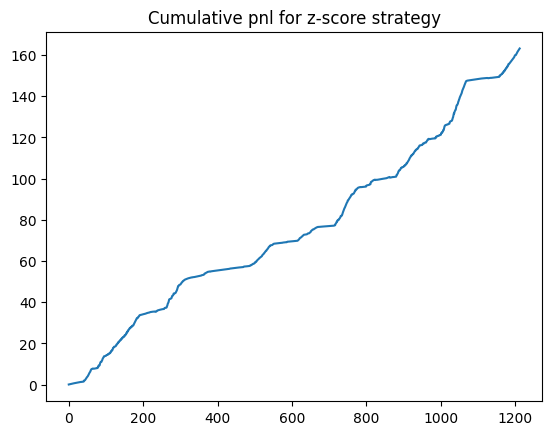

In [13]:
plt.plot(final_df['cumulative pnl'])
plt.title("Cumulative pnl for z-score strategy")

Maximum Drawdown is too less so Maximum Drawdown Duration is also almost negligible here.

# Rank Strategy

In [14]:
df = filled_df.copy(deep=True)
df['Spread'] = df['banknifty'] - df['nifty']

In [15]:
def rank(data, period=1875):
  rol_rank = data.rolling(period).rank(method='average', numeric_only=False, ascending=True, pct=True)
  return rol_rank

df['rank'] = rank(df['Spread']) # calculating ranking percentile using a rolling window of 5 days

In [16]:
df

,banknifty,nifty,tte,Spread,rank
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,NaN
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,NaN
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,NaN
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,NaN
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,NaN
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.349867
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.219733
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.302400


In [17]:
ranks = df['rank']
spreads = df['Spread']
ttes = df['tte']
times = df.index.values
signal_type = []
entry_time_new = []
exit_time_new = []
spread_for_entry_new = []
spread_for_exit_new = []
pnl_new = []

number_of_long_trades = 0
number_of_short_trades = 0

long = False
short = False
for index, rank in enumerate(ranks):
    if rank<0.25 and long is False:
        #print("entering long")
        number_of_long_trades += 1
        long = True
        signal_type.append(1)
        entry_time_new.append(times[index])
        spread_for_entry_new.append(spreads[index])

    if rank<0.50 and long is True:
        #print("continuing long")
        pass

    if rank>0.50 and long is True:
        #print("exiting long")
        long = False
        spread_for_exit_new.append(spreads[index])
        exit_spread_long = spreads[index]
        entry_spread_long = spread_for_entry_new[-1]
        tte_long = ttes[index]
        pnl_long = (exit_spread_long-entry_spread_long)*(ttes[index])**(0.7)
        exit_time_new.append(times[index])
        pnl_new.append(pnl_long)
    
    if rank>0.75 and short is False:
        #print("entering short")
        number_of_short_trades += 1
        short = True
        signal_type.append(-1)
        entry_time_new.append(times[index])
        spread_for_entry_new.append(spreads[index])

    if rank>0.50 and short is True:
        #print("continuing short")
        pass

    if rank<0.50 and short is True:
        #print("exiting short")
        short = False
        exit_spread_short = spreads[index]
        entry_spread_short = spread_for_entry_new[-1]
        spread_for_exit_new.append(exit_spread_short)
        exit_time_new.append(times[index])
        tte_long = ttes[index]
        pnl_short = (entry_spread_short-exit_spread_short)*(ttes[index])**(0.7)
        pnl_new.append(pnl_short)

if len(entry_time_new) == len(exit_time_new) +1:
    # We have not met exit condition to exit last trade
    del entry_time_new[-1]
    del spread_for_entry_new[-1]
    del signal_type[-1]
    
signal_type_modified = ['Long' if signal == 1 else 'Short' for signal in signal_type]

final_df_rank = pd.DataFrame({
    'Time_entry': entry_time_new,
    'Time_exit': exit_time_new,
    'Entry_spread': spread_for_entry_new,
    'Exit_spread': spread_for_exit_new,
    'PnL': pnl_new,
    'Signal': signal_type_modified
})

#This gives us a final_df which has all trades for the Ranking Trading Model

In [18]:
final_df_rank

,Time_entry,Time_exit,Entry_spread,Exit_spread,PnL,Signal
0,2021-01-07 15:25:00,2021-01-08 09:16:00,0.068015,0.077512,0.077331,Long
1,2021-01-08 09:17:00,2021-01-08 10:10:00,0.080126,0.076781,0.027238,Short
2,2021-01-08 11:34:00,2021-01-08 11:36:00,0.079553,0.076020,0.028769,Short
3,2021-01-08 11:59:00,2021-01-08 12:05:00,0.073831,0.078705,0.039679,Long
4,2021-01-08 12:23:00,2021-01-08 12:57:00,0.074298,0.077005,0.022040,Long
...,...,...,...,...,...,...
1487,2022-06-28 14:48:00,2022-06-28 14:49:00,0.027610,0.040989,0.144675,Long
1488,2022-06-28 14:49:00,2022-06-28 15:13:00,0.040989,0.026235,0.000000,Short
1489,2022-06-28 15:13:00,2022-06-28 15:17:00,0.026235,0.038726,0.135072,Long
1490,2022-06-28 15:17:00,2022-06-29 09:15:00,0.038726,0.029523,0.097192,Short


In [19]:
final_df_rank['cumulative pnl'] = final_df_rank['PnL'].cumsum() # cumulative pnl of z-score strategy

# Calculating drawdown series for z-score strategy
final_df_rank['cumulative max pnl'] = final_df_rank['cumulative pnl'].cummax()
final_df_rank['drawdown'] = (final_df_rank['cumulative pnl'] - final_df_rank['cumulative max pnl'])/final_df_rank['cumulative max pnl']

In [20]:
sharpe = final_df_rank['PnL'].mean()/final_df_rank['PnL'].std()
annualized_sharpe = np.sqrt(94500)*sharpe              #94500 = num of minutes in one trading day (375) * num of trading days in a year (252)
print("Annualized Sharpe value is", annualized_sharpe)
print("Profit is", final_df_rank['cumulative pnl'].iloc[-1])
print("Maximum drawdown is ", final_df_rank['drawdown'].min())

Annualized Sharpe value is 201.48874166792584
Profit is 157.7766807337942
Maximum drawdown is  -0.04131335793529423


Text(0.5, 1.0, 'Cumulative pnl for Rank strategy')

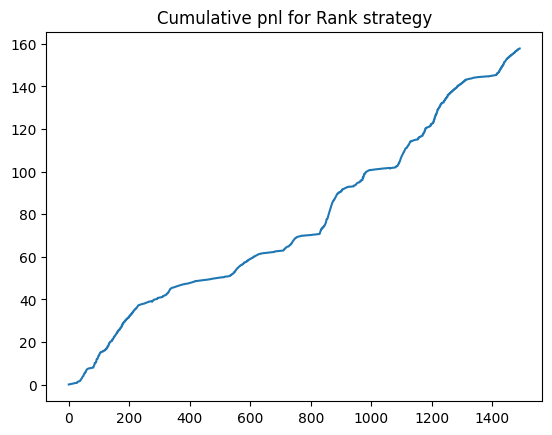

In [21]:
plt.plot(final_df_rank['cumulative pnl'])
plt.title("Cumulative pnl for Rank strategy")

Maximum Drawdown is negligible so maximum drawdown duration is also inapplicable here.

# GARCH Model

In [22]:
df = filled_df.copy(deep=True)
df['Spread'] = df['banknifty'] - df['nifty']

In [23]:
df

,banknifty,nifty,tte,Spread
time,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588
...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321


Text(0.5, 1.0, 'Spread Vs Time')

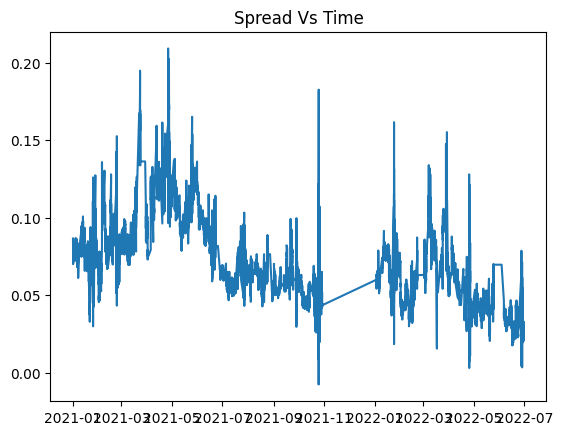

In [24]:
plt.plot(df['Spread'])
plt.title("Spread Vs Time")

Spread does not show stationarity. We induce stationarity using percentage difference and pass that as input to the GARCH model. After restoring the output of GARCH model from percentage difference to original scale, I have shown a plot of Predicted Spread Vs Actual Spread.

Text(0.5, 1.0, 'Stationary Spread Vs Time')

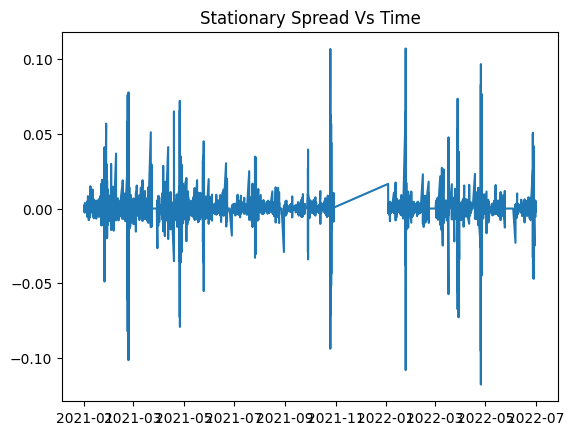

In [25]:
spread_data = df['Spread']
spread_data_stationary = spread_data.diff().dropna()

plt.plot(spread_data_stationary)
plt.title("Stationary Spread Vs Time")

We have some outliers in the stationary data.
We will remove the outliers that are more than **4** standard deviations away from the mean.

In [26]:
mean_value = spread_data_stationary.mean()
std_dev = spread_data_stationary.std()

lower_bound = mean_value - 4 * std_dev
upper_bound = mean_value + 4 * std_dev


spread_data_stationary = spread_data_stationary[(spread_data_stationary >= lower_bound) & 
                                                (spread_data_stationary <= upper_bound)]
actual_spread_data = df['Spread']
actual_spread_data = actual_spread_data[spread_data_stationary.index]


Text(0.5, 1.0, 'Stationary Spread Vs Time')

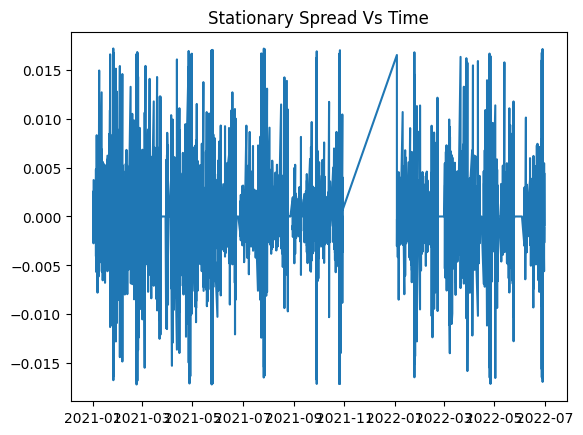

In [27]:
plt.plot(spread_data_stationary)
plt.title("Stationary Spread Vs Time")

We can see that the data is now stationary, centered around mean. We could apply the models now. However, on close observation, we see a lot of small gaps in the stationary spread data.

Text(0.5, 1.0, 'Stationary Spread Vs Time')

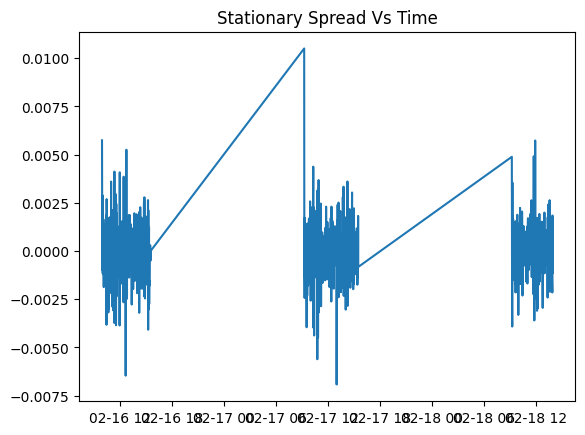

In [28]:
plt.plot(spread_data_stationary[12000:13000])
plt.title("Stationary Spread Vs Time")

These gaps are the non-trading hours and larger gaps for weekends. Changing the index to a numeric index will remove the gaps.

In [29]:
spread_data_stationary.reset_index(drop=True, inplace=True)
#spread_data_stationary['time'] = spread_data_stationary.index

#print(spread_data_stationary['time'].values)

Text(0.5, 1.0, 'Stationary Spread Vs Time')

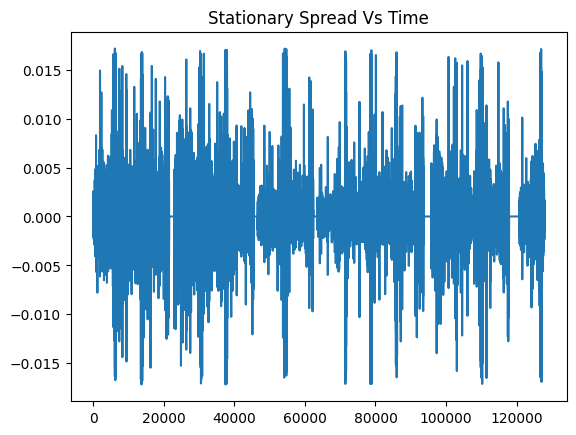

In [30]:
plt.plot(spread_data_stationary[0:-1])
plt.title("Stationary Spread Vs Time")

This removes the gaps due to non-trading hours, weekends and the missing days in the data.

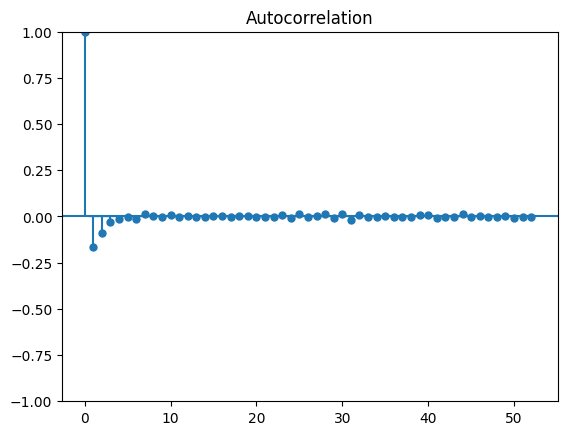

In [31]:
plot_acf((spread_data_stationary[0:-1]))
plt.show()

The autocorrelation plot shows 3 significant lag variances. Hence p for the GARCH model should be 3.

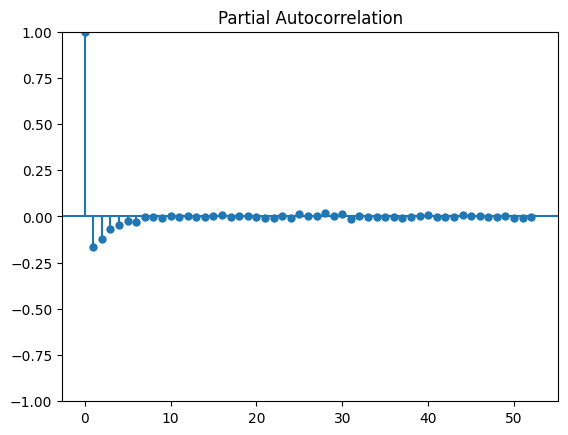

In [32]:
plot_pacf((spread_data_stationary[0:-1]))
plt.show()

The partial autocorrelation plot shows 3 significant lag residual errors . Hence q for the GARCH model should be 3.

In [33]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys

sys.stderr = open('/dev/null', 'w') # Removes certain warnings from the output

# Using 70% of the data to train the model
split_index = int(len(spread_data_stationary) * 0.7)


predicted_spreads = []

# I have taken a limited range to iterate over so that the loop does not take too long
for i in range(split_index+1000, split_index+2000):
    print()
    
    # Splitting the data into training and testing sets
    train_data = spread_data_stationary[:i]
    test_data = spread_data_stationary[i:i+1]
    
    # Fitting the GARCH(3,3) model using training data
    garch_model = arch_model(train_data, vol='Garch', p=3, q=3)
    garch_results = garch_model.fit(disp='off')
    
    # Forecast spread for the next period
    forecast = garch_results.forecast(horizon=1)
    predicted_spread_stationary = forecast.mean.iloc[-1].values[0]

    # Revert the predicted spread back to its original scale
    predicted_spread = actual_spread_data[i-1] + predicted_spread_stationary.cumsum()
    
    if predicted_spread<1:
        predicted_spread = actual_spread_data[i-1]
    
    predicted_spreads.append(predicted_spread)

    
    actual_spread = spread_data[i]
    mae = mean_absolute_error([actual_spread], [predicted_spread])
    mse = mean_squared_error([actual_spread], [predicted_spread])
    print(f"Actual Spread: {actual_spread}, Predicted Spread: {predicted_spread}")
    #print(f"MAE: {mae}, MSE: {mse}")

# Converting the list of predicted spreads to a pandas Series
predicted_spreads_series = pd.Series(predicted_spreads, index=spread_data.index[split_index+1000:split_index+2000])

#print(predicted_spreads_series)



Actual Spread: 0.04187449999999998, Predicted Spread: 0.05111850000000001

Actual Spread: 0.04201550000000001, Predicted Spread: 0.050804000000000016

Actual Spread: 0.04219299999999998, Predicted Spread: 0.05055349999999997

Actual Spread: 0.04195549999999998, Predicted Spread: 0.050481499999999985

Actual Spread: 0.041942499999999994, Predicted Spread: 0.049943499999999974

Actual Spread: 0.042157, Predicted Spread: 0.050653000000000004

Actual Spread: 0.04299999999999998, Predicted Spread: 0.05105850000000001

Actual Spread: 0.04286599999999999, Predicted Spread: 0.05122650000000001

Actual Spread: 0.04301349999999998, Predicted Spread: 0.0499725

Actual Spread: 0.042786500000000005, Predicted Spread: 0.050704

Actual Spread: 0.04221550000000002, Predicted Spread: 0.050538

Actual Spread: 0.04198249999999998, Predicted Spread: 0.05116599999999999

Actual Spread: 0.04216199999999998, Predicted Spread: 0.05230950000000001

Actual Spread: 0.04297300000000001, Predicted Spread: 0.05130

In [38]:
part_data = actual_spread_data[split_index+1000:split_index+2000]

In [39]:
predicted_spreads_series = predicted_spreads_series.reset_index(drop=True)

# Reset index for check_data
part_data = part_data.reset_index(drop=True)

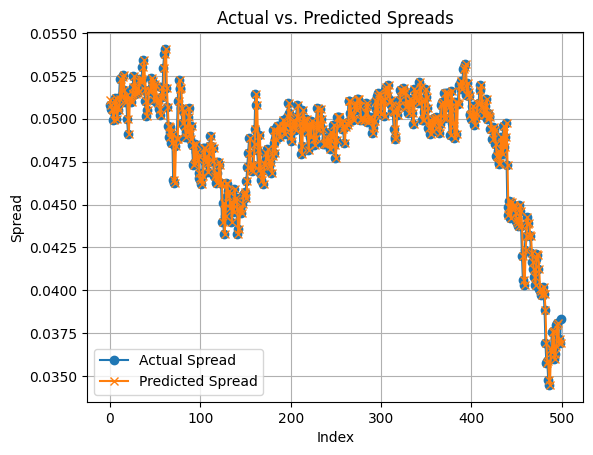

In [40]:
plot_predicted_data = predicted_spreads_series[:500]
plot_actual_data = part_data[:500]
plt.plot(plot_actual_data, label='Actual Spread', marker='o')  # Plot actual_spread
plt.plot(plot_predicted_data, label='Predicted Spread', marker='x')  # Plot predicted_spreads_series
plt.xlabel('Index')
plt.ylabel('Spread')
plt.title('Actual vs. Predicted Spreads')
plt.legend()  # Show legend
plt.grid(True)  # Add grid
plt.show()

The predicted spread matches well with the the actual spread values. This prediction model can be used to make a strategy to trade based on IV's of Bank Nifty and Nifty. I was not sure if the same P/L formula would be applicable here so I have not applied it here.

A few notes for the assignment:

At various places, we have used hard-coded values of z-threshold or ranks, which might introduce Data-Snooping Bias. With more data than IV, I think a parameter-less model can be possible.

I am not sure if the transaction costs were included in P/L formula or not. If not, I believe such medium term trades in high quantity might have considerable transaction costs which would affect the profitability of the strategy.

Thank you!

Priyaank Sheth